In [1]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import cmath
import math
from scipy import io, stats
from scipy.stats import mannwhitneyu, normaltest, zscore, wilcoxon, ttest_rel
from statannotations.Annotator import Annotator
import matplotlib as mpl
import matplotlib.patheffects as path_effects

cwd = os.getcwd()
sys.path.append(cwd+"/../handy_functions")

from concat_pickles import get_outputs,get_outputs_wTraces,print_df
from metrics import get_R2

fig_folder = '/Users/kendranoneman/Figures/neural-decoding'

data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)
sess_size = len(out_times)

reds =[(1.0, 0.0, 0.0), (0.95, 0.0, 0.0), (0.9, 0.0, 0.0), (0.8, 0.0, 0.0), (0.7, 0.0, 0.0), (0.6, 0.0, 0.0), (0.5, 0.0, 0.0), (0.4, 0.0, 0.0), (0.3, 0.0, 0.0), (0.2, 0.0, 0.0)]
oranges = [[1.0, 0.6, 0.0], [1.0, 0.5, 0.0], [0.9, 0.45,0.0], [0.9, 0.4, 0.0], [0.8, 0.4, 0.0], [0.7, 0.3, 0.0], [0.6, 0.2, 0.0], [0.5, 0.1, 0.0]]
pinks = [[1.0, 0.6, 0.7], [1.0, 0.55, 0.7], [1.0, 0.45, 0.65], [1.0, 0.3, 0.6], [0.9, 0.25, 0.6], [0.8, 0.2, 0.55], [0.7, 0.15, 0.5], [0.6, 0.1, 0.45]]
grays = [(0.95,0.75,0.75),(0.9,0.7,0.7),(0.85,0.65,0.65),(0.8,0.6,0.6),(0.75,0.55,0.55),(0.7,0.5,0.5),(0.65,0.45,0.45),(0.6,0.4,0.4)]

pal = [reds,oranges,pinks]

# Figure 1: What are we decoding?

In [ ]:
from preprocessing_funcs import bin_spikes
from preprocessing_funcs import bin_output

data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
dt = 50
data = io.loadmat(data_folder+'vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
vel         =  data['vels']
acc          =  data['acc']
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv(data_folder+'units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.15)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.15)].index
    
##############################################################################################
trial = [1861] #1858. 1861. 1879. 1882. 1883.

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(10, 3))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='mediumpurple', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='forestgreen', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2a, ax = plt.subplots(figsize=(10, 5.5))
fig2a.tight_layout()

poses = pos[np.isin(conditions[:,0],trial)]
ttt = 4
print([poses[320*ttt:320*(ttt+1),1].mean(),poses[320*ttt:320*(ttt+1),0].mean()])

ax.plot((poses[:,0]), label='HE', color='gray', linestyle='-', linewidth=10)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='--', linewidth=10)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig2a.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight');

# Figure 2: spike raster + behavior (few trials)

In [ ]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
dt = 50
data = io.loadmat(data_folder+'vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv(data_folder+'units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.2)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.2)].index
    
##############################################################################################
trial = [1858,1861] #1858. 1861. 1879. 1882. 1883.

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(10, 3))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
#ax.set_xticks([0,100])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2, ax = plt.subplots(figsize=(10, 2))
fig2.tight_layout()

poses = pos[np.isin(conditions[:,0],trial)]

ax.plot(poses[:,0], label='HE', color='gray', linestyle='--', linewidth=4)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='-', linewidth=4)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig2.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight')

# Figure 3: How well do the eight decoders perform?

In [135]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figure3/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["-o0-"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+sub_folder,["-o1-"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+sub_folder,["-o2-"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
all_r2 = []
for i in range(10):
    all_r2.append(df0.loc[(df0['model']==7)].groupby('outer_fold')['R2_mn'].mean().values[i].mean())
best_fold = np.array(all_r2).argmax()

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']
df['train_time'] = df['train_time'] / 60

df.head(1)

,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,model,output,nMT,nFEF,...,rho_mn,R2sh_x,R2sh_y,R2sh_mn,R2tr_x,R2tr_y,R2tr_mn,num_bins,preProcessTime_corrected,inference_time
0,29,0,10,1,400,50,0,position,24,41,...,0.809132,-0.304213,-0.329013,-0.316613,0.643491,0.6786,0.661046,381760.0,0.201741,0.204019


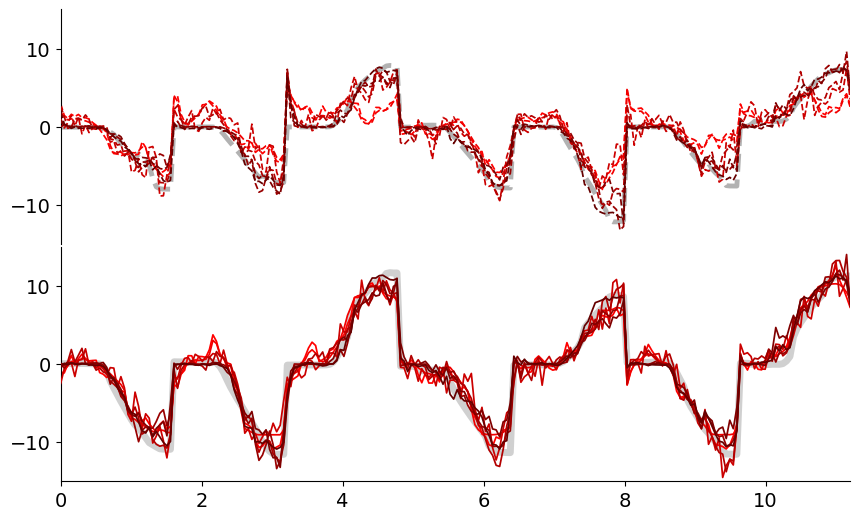

In [136]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2,1,figsize=(9,5.5))#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 1.25
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all0
y_test_predicted = yTestPred_all0

mdls = df0[(df0['outer_fold'] == best_fold) & (df0['downsample_factor'] == 1) & (df0['output_binWidth'] == 50)].index.values
jmdls =[0,1,3,4,5,6,7]

conds = conds0[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 0
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)

Nts = 7
plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
#x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000
x = np.linspace(0,Nts*1.6,start_end.shape[0])

axes[0].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.5, linewidth=3.5, linestyle='dashed', label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j!=4:
        axes[0].plot(x,y_test_predicted[i][start_end,0], color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[0].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)

axes[0].set_xlim(x[0],x[-1])
axes[0].set_ylim(-15,15)
axes[0].set_xticks([])
axes[0].set_yticks([-10,0,10])
axes[0].spines['right'].set_color('none')
axes[0].spines['bottom'].set_color('none')
axes[0].spines['top'].set_color('none')

axes[1].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j!=4:
        axes[1].plot(x,y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        
axes[1].set_xlim(x[0],x[-1])
axes[1].set_ylim(-15,15)
axes[1].set_yticks([-10,0,10])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.25, hspace=0.01)
fig.savefig(fig_folder+'/traces_8models-pos.png', dpi=600, bbox_inches='tight')

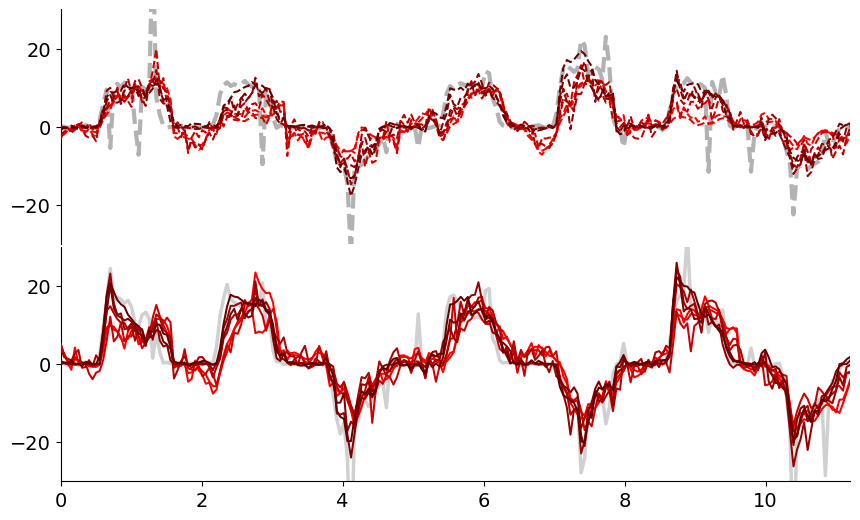

In [137]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2,1,figsize=(9,5.5))#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 1.45
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all1
y_test_predicted = yTestPred_all1

mdls = df1[(df1['outer_fold'] == best_fold) & (df1['downsample_factor'] == 1) & (df1['output_binWidth'] == 50)].index.values
jmdls =[0,1,3,4,5,6,7]
Nts = 7

conds = conds1[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

'''
R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 0
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)
'''

#plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
#bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
#x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000
x = np.linspace(0,Nts*1.6,start_end.shape[0])

axes[0].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.5, linewidth=3, linestyle='dashed', label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j!=4:
        axes[0].plot(x,y_test_predicted[i][start_end,0], color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[0].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)

axes[0].set_xlim(x[0],x[-1])
axes[0].set_ylim(-30,30)
axes[0].set_xticks([])
axes[0].set_yticks([-20,0,20])
axes[0].spines['right'].set_color('none')
axes[0].spines['bottom'].set_color('none')
axes[0].spines['top'].set_color('none')

axes[1].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=2.5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j!=4:
        axes[1].plot(x,y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        
axes[1].set_xlim(x[0],x[-1])
axes[1].set_ylim(-30,30)
axes[1].set_yticks([-20,0,20])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.25, hspace=0.01)
fig.savefig(fig_folder+'/traces_8models-vel.png', dpi=600, bbox_inches='tight')

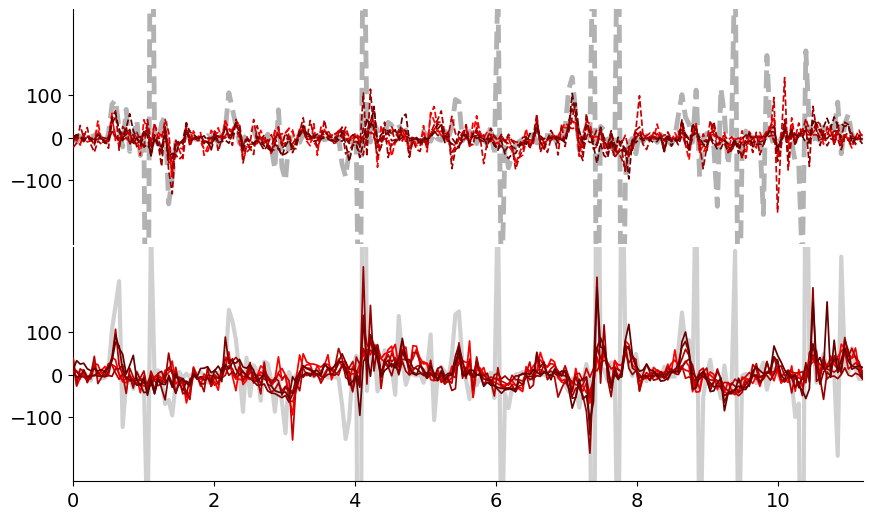

In [138]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2,1,figsize=(9,5.5))#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 1.25
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all2
y_test_predicted = yTestPred_all2

mdls = df2[(df2['outer_fold'] == best_fold) & (df2['downsample_factor'] == 1) & (df2['output_binWidth'] == 50)].index.values
jmdls =[0,1,3,4,5,6,7]
Nts = 7

conds = conds2[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

'''
R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 0
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)
'''

#plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
#bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
#x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000
x = np.linspace(0,Nts*1.6,start_end.shape[0])

axes[0].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.5, linewidth=3.5, linestyle='dashed', label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j!=4:
        axes[0].plot(x,y_test_predicted[i][start_end,0], color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[0].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)

axes[0].set_xlim(x[0],x[-1])
axes[0].set_ylim(-250,300)
axes[0].set_xticks([])
axes[0].set_yticks([-100,0,100])
axes[0].spines['right'].set_color('none')
axes[0].spines['bottom'].set_color('none')
axes[0].spines['top'].set_color('none')

axes[1].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=3, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j!=4:
        axes[1].plot(x,y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        
axes[1].set_xlim(x[0],x[-1])
axes[1].set_ylim(-250,300)
axes[1].set_yticks([-100,0,100])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.25, hspace=0.01)
fig.savefig(fig_folder+'/traces_8models-acc.png', dpi=600, bbox_inches='tight')

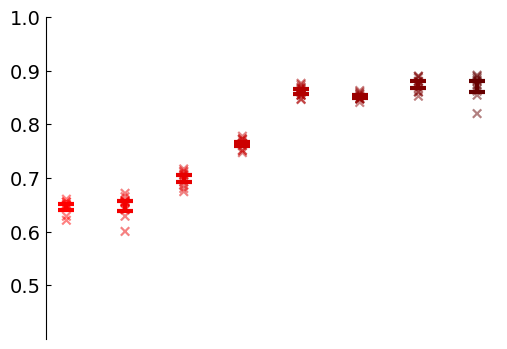

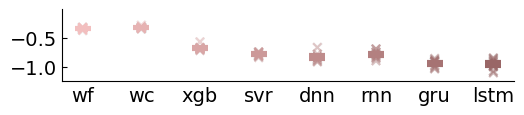

In [141]:
########################################### position ##########################################
values = ['R2_mn','R2sh_mn']
b = 50
o = 'position'

wf   = (df.loc[(df['model']==0) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
wc   = (df.loc[(df['model']==1) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
#kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==1)]).groupby('outer_fold')[values].mean().values
xgb   = (df.loc[(df['model']==3) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
svr   = (df.loc[(df['model']==4) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
dnn  = (df.loc[(df['model']==5) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
rnn  = (df.loc[(df['model']==6) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
gru  = (df.loc[(df['model']==7) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
lstm = (df.loc[(df['model']==8) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values

n=10
means=([np.mean(wf,axis=0),np.mean(wc,axis=0),np.mean(xgb,axis=0),np.mean(svr,axis=0),np.mean(dnn,axis=0),np.mean(rnn,axis=0),np.mean(gru,axis=0),np.mean(lstm,axis=0)])
err=([np.std(wf,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(wc,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(xgb,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(svr,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(dnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(rnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(gru,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(lstm,axis=0)*np.sqrt(1./n+1./(n-1))])
ind = np.arange(len(err)) #X values for plotting

# Standard R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 4), sharey=True)
fig.tight_layout()
val = 0

for pos, y, yerr, color in zip(ind, means, err, reds): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=3, capsize=6, capthick=3, color=color, zorder=0)

    ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(reds[j])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
    ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])

ax.set_ylim(0.4,1);
fig.savefig(fig_folder+'/mnR2_8models-pos.png', dpi=600, bbox_inches='tight')

# Shuffled R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 1.5), sharey=True)
fig.tight_layout()
val = 1

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=3, capsize=6, capthick=3, color=color, zorder=0)

    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)

ax.set_ylim(-1.25,0);
ax.set_yticks([-1.0,-0.5])
fig.savefig(fig_folder+'/mnR2_8models-posnull.png', dpi=600, bbox_inches='tight')

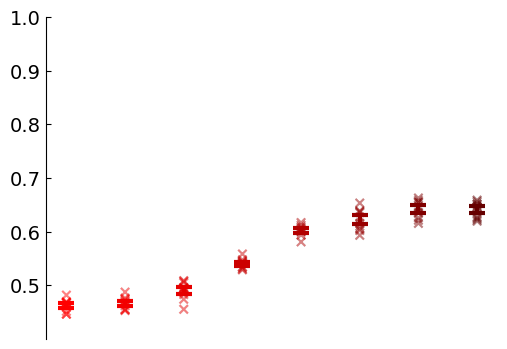

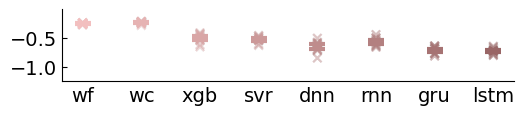

In [142]:
########################################### velocity ##########################################
values = ['R2_mn','R2sh_mn']
b = 50
o = 'velocity'

wf   = (df.loc[(df['model']==0) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
wc   = (df.loc[(df['model']==1) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
#kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==1)]).groupby('outer_fold')[values].mean().values
xgb   = (df.loc[(df['model']==3) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
svr   = (df.loc[(df['model']==4) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
dnn  = (df.loc[(df['model']==5) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
rnn  = (df.loc[(df['model']==6) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
gru  = (df.loc[(df['model']==7) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
lstm = (df.loc[(df['model']==8) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values

n=10
means=([np.mean(wf,axis=0),np.mean(wc,axis=0),np.mean(xgb,axis=0),np.mean(svr,axis=0),np.mean(dnn,axis=0),np.mean(rnn,axis=0),np.mean(gru,axis=0),np.mean(lstm,axis=0)])
err=([np.std(wf,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(wc,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(xgb,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(svr,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(dnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(rnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(gru,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(lstm,axis=0)*np.sqrt(1./n+1./(n-1))])
ind = np.arange(len(err)) #X values for plotting

# Standard R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 4), sharey=True)
fig.tight_layout()
val = 0

for pos, y, yerr, color in zip(ind, means, err, reds): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=3, capsize=6, capthick=3, color=color, zorder=0)

    ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(reds[j])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
    ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])

ax.set_ylim(0.4,1);
fig.savefig(fig_folder+'/mnR2_8models-vel.png', dpi=600, bbox_inches='tight')

# Shuffled R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 1.5), sharey=True)
fig.tight_layout()
val = 1

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=3, capsize=6, capthick=3, color=color, zorder=0)

    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)

ax.set_ylim(-1.25,0);
ax.set_yticks([-1.0,-0.5])
fig.savefig(fig_folder+'/mnR2_8models-velnull.png', dpi=600, bbox_inches='tight')

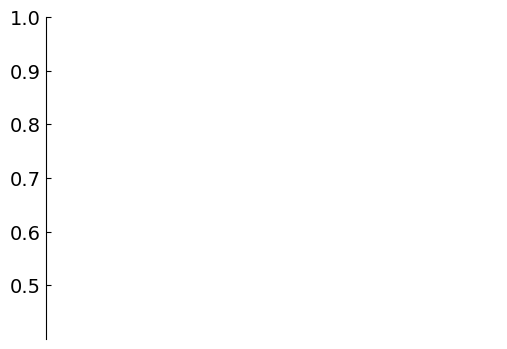

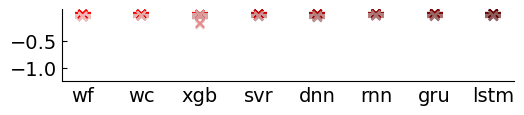

In [143]:
########################################### acceleration ##########################################
values = ['R2_mn','R2sh_mn']
b = 50
o = 'acceleration'

wf   = (df.loc[(df['model']==0) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
wc   = (df.loc[(df['model']==1) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
#kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==1)]).groupby('outer_fold')[values].mean().values
xgb   = (df.loc[(df['model']==3) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
svr   = (df.loc[(df['model']==4) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
dnn  = (df.loc[(df['model']==5) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
rnn  = (df.loc[(df['model']==6) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
gru  = (df.loc[(df['model']==7) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
lstm = (df.loc[(df['model']==8) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values

n=10
means=([np.mean(wf,axis=0),np.mean(wc,axis=0),np.mean(xgb,axis=0),np.mean(svr,axis=0),np.mean(dnn,axis=0),np.mean(rnn,axis=0),np.mean(gru,axis=0),np.mean(lstm,axis=0)])
err=([np.std(wf,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(wc,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(xgb,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(svr,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(dnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(rnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(gru,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(lstm,axis=0)*np.sqrt(1./n+1./(n-1))])
ind = np.arange(len(err)) #X values for plotting

# positive R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 4), sharey=True)
fig.tight_layout()
val = 0

for pos, y, yerr, color in zip(ind, means, err, reds): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=3, capsize=6, capthick=3, color=color, zorder=0)

    ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    #ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(reds[j])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])
#ax.set_yticks([-1.0,-0.5,0,0.5,0.6,0.7,0.8,0.9,1.0])

ax.set_ylim(0.4,1);
#fig.savefig(fig_folder+'/mnR2_8models-acc.png', dpi=600, bbox_inches='tight')

val = 1

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=3, capsize=6, capthick=3, color=color, zorder=0)

    #ax.set_xticks([0,1,2,3,4,5,6,7])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)

fig.savefig(fig_folder+'/mnR2_8models-acc.png', dpi=600, bbox_inches='tight')

#################################################################################################
# negative R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 1.5), sharey=True)
fig.tight_layout()
val = 0

for pos, y, yerr, color in zip(ind, means, err, reds): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=3, capsize=6, capthick=3, color=color, zorder=0)

    #ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    #ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(reds[j])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
ax.set_yticks([-0.5,-1])
#ax.set_yticks([-1.0,-0.5,0,0.5,0.6,0.7,0.8,0.9,1.0])

ax.set_ylim(-1.25,0.1);
#fig.savefig(fig_folder+'/mnR2_8models-acc.png', dpi=600, bbox_inches='tight')

val = 1

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=3, capsize=6, capthick=3, color=color, zorder=0)

    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)

fig.savefig(fig_folder+'/mnR2_8models-accnull.png', dpi=600, bbox_inches='tight')

# Figure 4: How do output params affect decoding performance?

In [166]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figure3/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["-o0-"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+sub_folder,["-o1-"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+sub_folder,["-o2-"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
all_r2 = []
for i in range(10):
    all_r2.append(df0.loc[(df0['model']==7)].groupby('outer_fold')['R2_mn'].mean().values[i].mean())
best_fold = np.array(all_r2).argmax()

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']

df['train_time'] = df['train_time'] / 60

df.head(1)

,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,model,output,nMT,nFEF,...,rho_mn,R2sh_x,R2sh_y,R2sh_mn,R2tr_x,R2tr_y,R2tr_mn,num_bins,preProcessTime_corrected,inference_time
0,29,0,10,1,400,50,0,position,24,41,...,0.809132,-0.304213,-0.329013,-0.316613,0.643491,0.6786,0.661046,381760.0,0.201741,0.204019


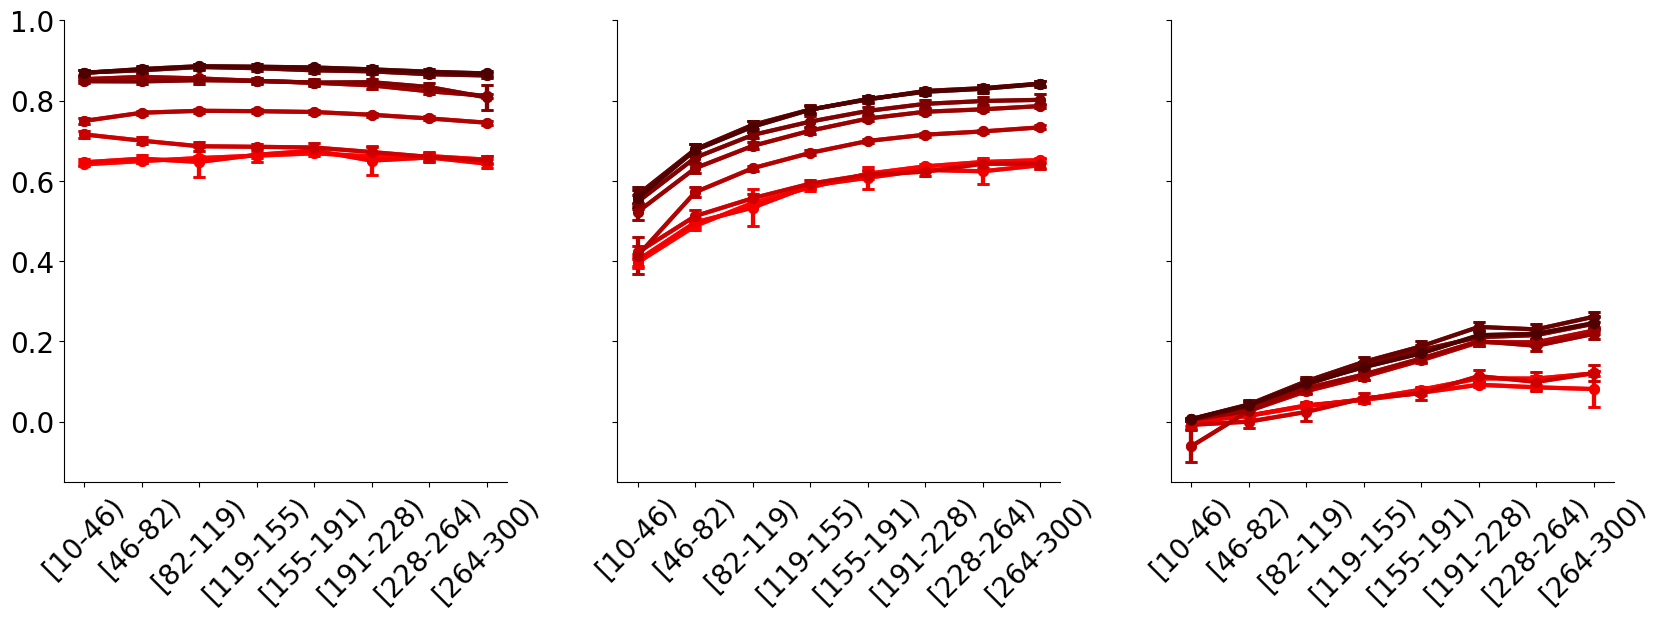

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)#, gridspec_kw={'height_ratios': [3, 2]})

#plt.subplots_adjust(hspace=0.1)

num_bins = 8
mayo = 0
behs = ['R2_mn'] #, 'train_time'
kins = ['position', 'velocity', 'acceleration']

for k, kin in enumerate(kins):
    DF = df.loc[(df['output'] == kin) & (df['output_binWidth']!=0) & (df['R2_mn'] >-1)]

    for i, beh in enumerate(behs):
        dff = DF[['model', 'output_binWidth', beh, 'outer_fold']]
        obw = dff['output_binWidth'].unique()

        df_mn = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].mean().reset_index(name="mR2")
        df_sd = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].std().reset_index(name="sR2")

        for m in DF['model'].unique():
            mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
            mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

            # Get the centers of the bins for x-values
            bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)]['output_binWidth']]
            bin_mins = [bin.left for bin in df_mn[(df_mn['model'] == m)]['output_binWidth']]
            bin_maxs = [bin.right for bin in df_mn[(df_mn['model'] == m)]['output_binWidth']]
            
            # Round bin min and max values to the nearest integer
            bin_mins = [round(val) for val in bin_mins]
            bin_maxs = [round(val) for val in bin_maxs]

            ax[k].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=reds[m], zorder=2)
            ax[k].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=reds[m], zorder=3)

            # Set the x-tick labels as bin minimum and maximum for each point
            x_tick_labels = [f"[{min_val}-{max_val})" for min_val, max_val in zip(bin_mins, bin_maxs)]
            ax[k].set_xticks(bin_centers)
            ax[k].set_xticklabels(x_tick_labels, rotation=45)
            
        ax[k].spines['right'].set_color('none')
        ax[k].spines['top'].set_color('none')
    #ax[0].set_ylim(0.35,0.92)
    #ax[1].set_ylim(0.35,0.92)
    #ax[2].set_ylim(-0.05,0.42)
    ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    #ax[1].set_yticks([0.4,0.5,0.6,0.7,0.8,0.9])
    #ax[2].set_yticks([0.0,0.1,0.2,0.3,0.4])
    
    #ax[1, k].set_ylim(0,325)
    #ax[1, 1].set_yticks([])
    #ax[1, 2].set_yticks([])
    
plt.subplots_adjust(wspace=0.25, hspace=0.1)

if mayo==1:
    ax[0].set_ylabel('$R^2$')
    #ax[1, 0].set_ylabel('time elapsed (s)')
    ax[1].set_xlabel('output bin width (ms)')
    ax[0].set_title('position')
    ax[1].set_title('velocity')
    ax[2].set_title('acceleration')
else:
    blah = 1
    fig.savefig(fig_folder+'/r2tt_outputBinWidth-onesess.png', dpi=600, bbox_inches='tight') 


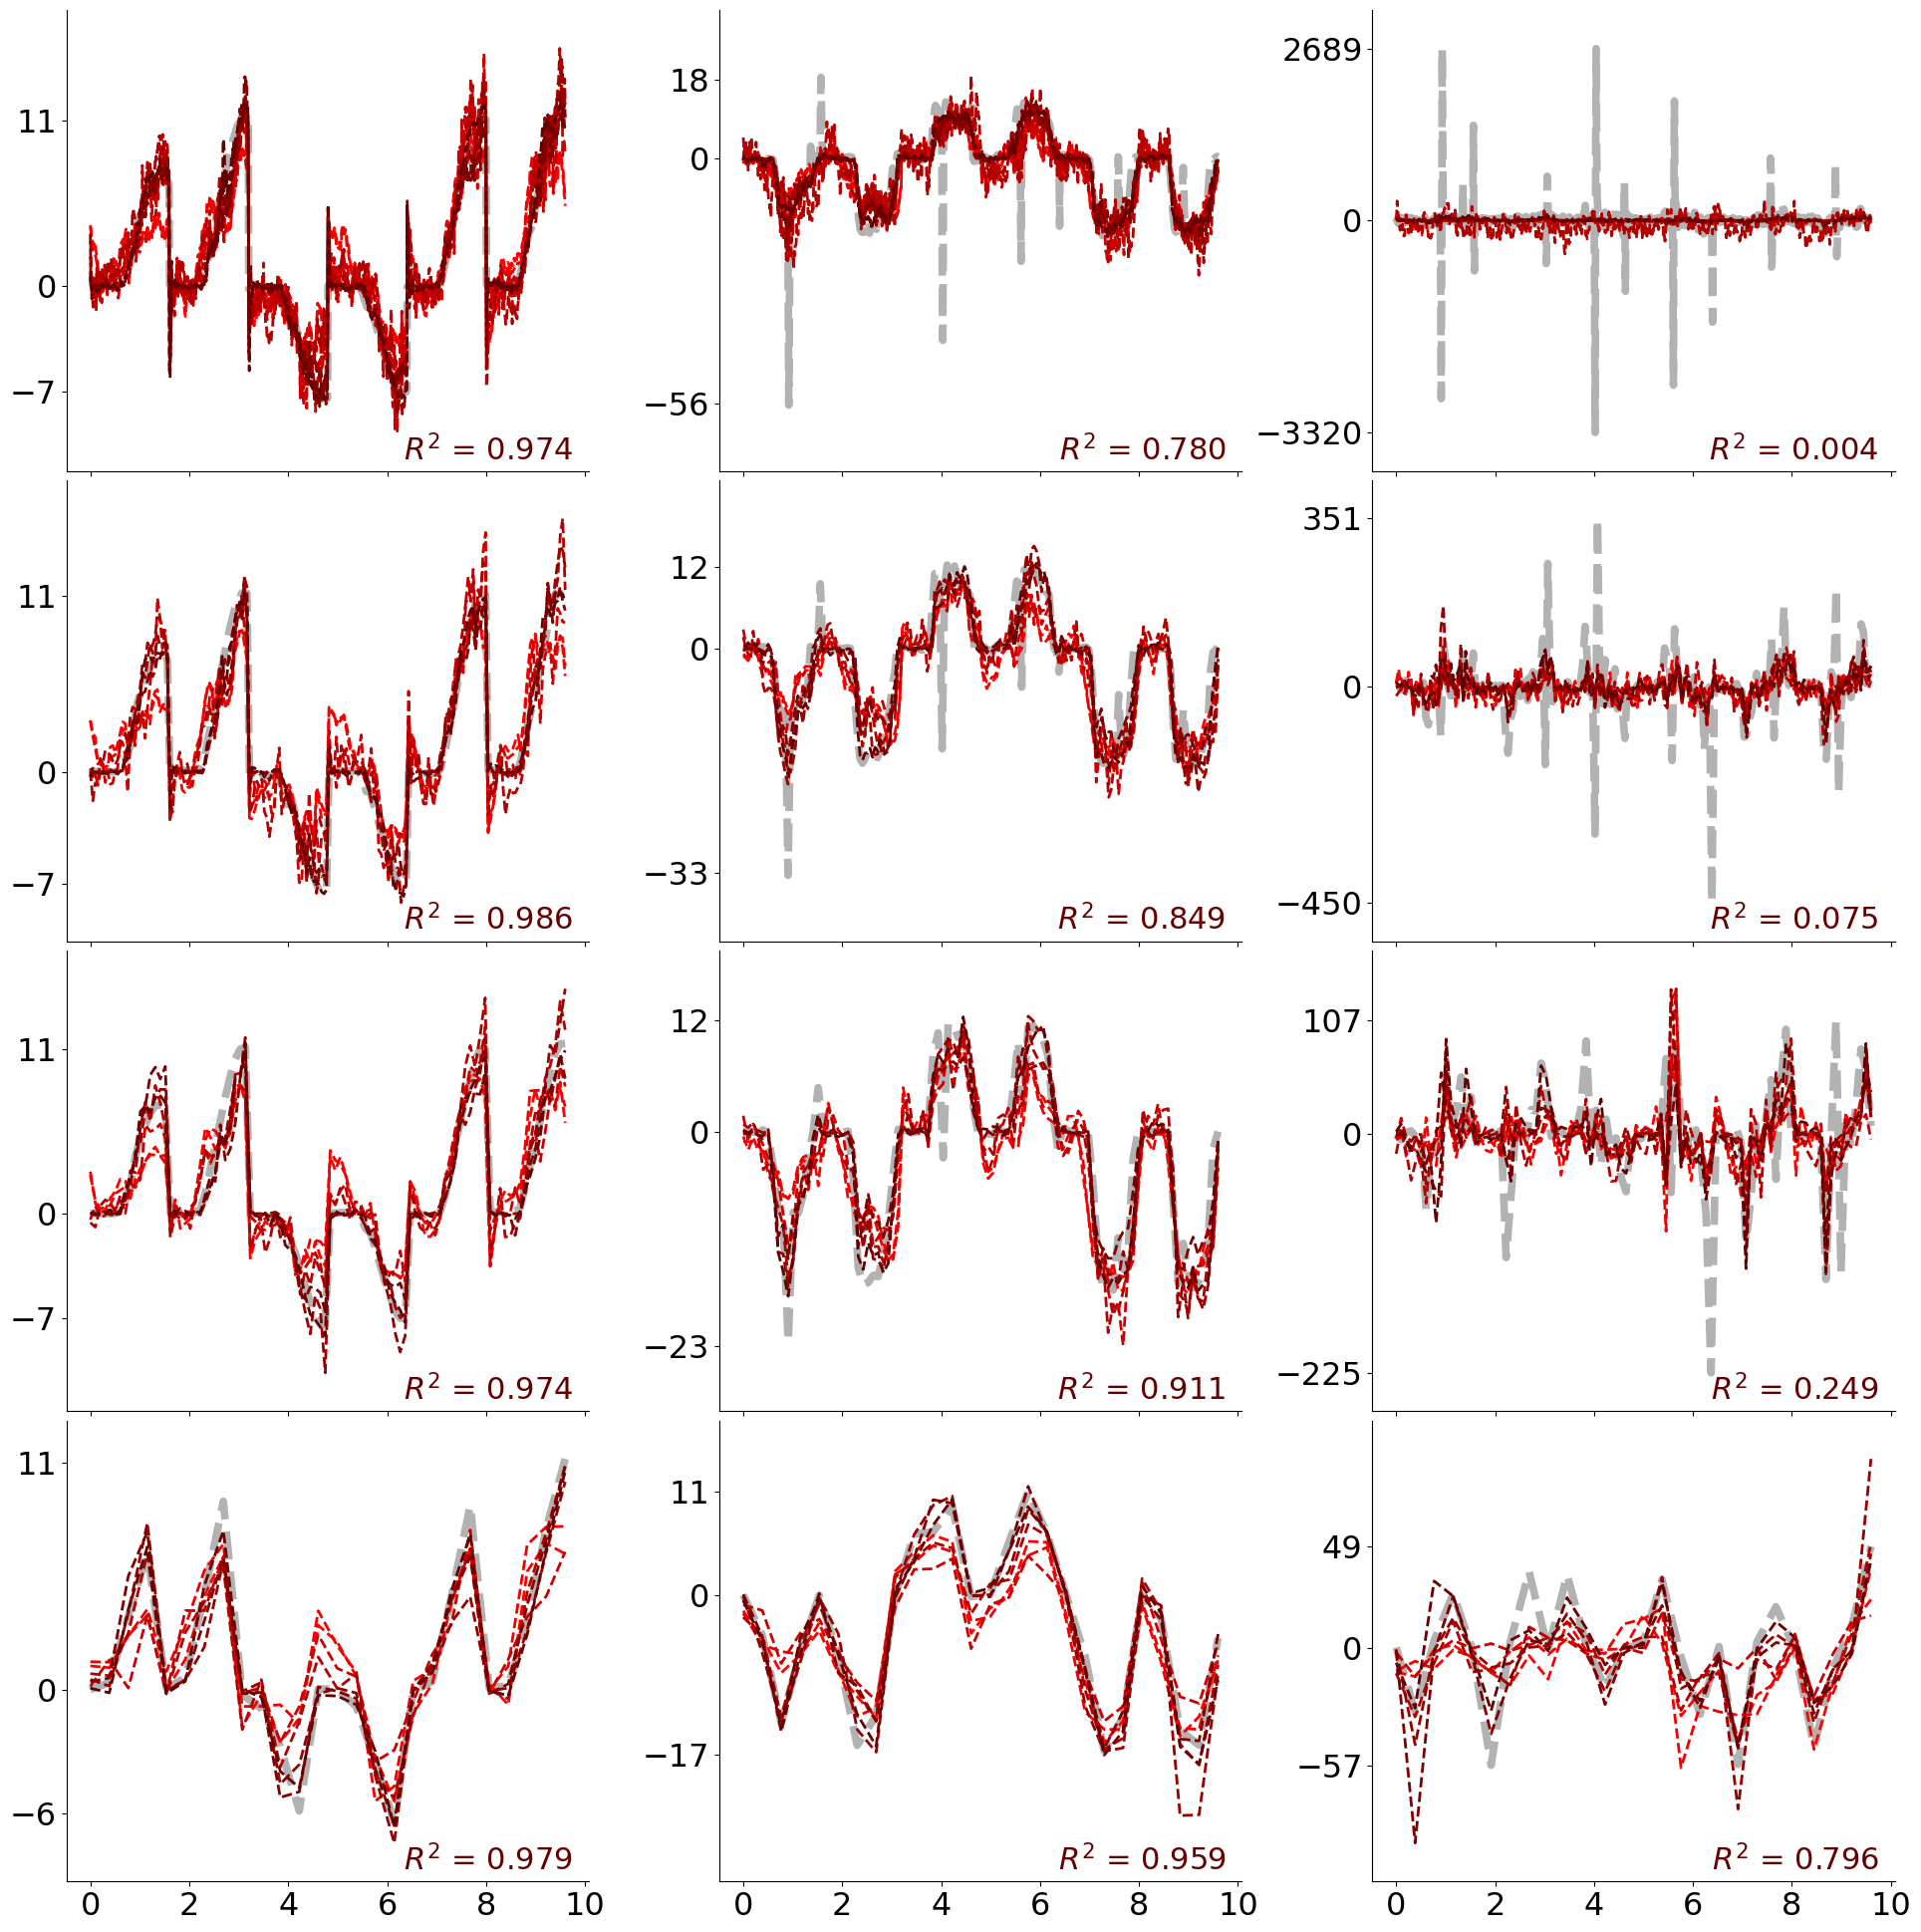

In [168]:
bws = [10,50,100,300]
mayo = 0
Nts = 6

plt.rcParams.update({'font.size': 23})
fig, axes = plt.subplots(len(bws),3,figsize=(20,20), sharex=True, sharey=False)#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 2
mdls = df0[(df0['outer_fold'] == best_fold) & (df0['output_binWidth'] == 50) & (df0['R2_mn']>-1)].index.values
jmdls =[0,1,3,4,5,6,7]

conds = conds0[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

y_test = yTest_all0
y_test_predicted = yTestPred_all0
    
R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 4
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)

plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

#################
R2_allParams = np.zeros((len(bws),3))
for b, bw in enumerate(bws):
    for k in range(3):
        if k==0:
            y_test = yTest_all0
            y_test_predicted = yTestPred_all0
            DF = df0
        elif k==1:
            y_test = yTest_all1
            y_test_predicted = yTestPred_all1
            DF = df1
        else:
            y_test = yTest_all2
            y_test_predicted = yTestPred_all2
            DF = df2
            
        mdls = DF[(DF['outer_fold'] == best_fold) & (DF['output_binWidth'] == bw) & (DF['R2_mn']>-1)].index.values
        jmdls =[0,1,3,4,5,6,7]

        conds = conds0[mdls[0]]
        trl_nums = np.unique(conds[:,0])
        trl_nums, indices = np.unique(conds[:,0], return_index=True)

        start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
        #x = np.arange(0, start_end.shape[0]*bw*Nts, bw*Nts)*2 / 10000
        x = np.linspace(0,Nts*1.6,start_end.shape[0])
        
        axes[b,k].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.5, linewidth=5.5, linestyle='dashed', label='true (horizontal)',zorder=0)
        for i,j in zip(mdls,jmdls):
            if j!=4:
                axes[b,k].plot(x,y_test_predicted[i][start_end,0], color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)
                R2_allParams[b,k] = get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0])
            else:
                axes[b,k].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)
                R2_allParams[b,k] = get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]))
           
        axes[b,k].spines['right'].set_color('none')
        axes[b,k].spines['top'].set_color('none')
        axes[b,k].set_yticks([round(min(y_test[i][start_end,0])),0,round(max(y_test[i][start_end,0]))])
        
        if k==0:
            axes[b, k].margins(y=0.1)
        elif k==1:
            axes[b, k].margins(y=0.2)
        else:
            axes[b, k].margins(y=0.1)
        
        text_box = f"$R^2$ = {R2_allParams[b, k]:.3f}"
        axes[b, k].text(0.97, 0.01, text_box, transform=axes[b, k].transAxes, fontsize=22, ha='right', va='bottom', color=reds[j])
    if mayo==1:
        axes[b,0].set_ylabel(f'bw={bw}')
        
axes[0,0].set_xticks([0,2,4,6,8,10])

plt.subplots_adjust(wspace=0.25, hspace=0.02)
if mayo==1:
    axes[0, 0].set_title('position')
    axes[0, 1].set_title('velocity')
    axes[0, 2].set_title('acceleration')
    axes[3, 1].set_xlabel('time (ms)')
else:
    blah = 1
    fig.savefig(fig_folder+'/traces_outBinWidth-posVelAcc.png', dpi=600, bbox_inches='tight')
    

# Figure 5: How do input params affect decoding performance?

In [171]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figure4/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["-o0-"],column_names)
#df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+sub_folder,["-o1-"],column_names)
#df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+sub_folder,["-o2-"],column_names)

df = df0
all_r2 = []
for i in range(10):
    all_r2.append(df0.loc[(df0['model']==0)].groupby('outer_fold')['R2_mn'].mean().values[i].mean())
best_fold = np.array(all_r2).argmax()

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']

df['train_time'] = df['train_time'] / 60

#df = df[df['R2_mn'] >= 0]

df.head(1)

,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,model,output,nMT,nFEF,...,rho_mn,R2sh_x,R2sh_y,R2sh_mn,R2tr_x,R2tr_y,R2tr_mn,num_bins,preProcessTime_corrected,inference_time
0,29,0,100,1,10,10,0,position,24,41,...,0.391505,-0.1319,-0.125847,-0.128873,0.147577,0.152999,0.150288,38176.0,0.185959,0.186533


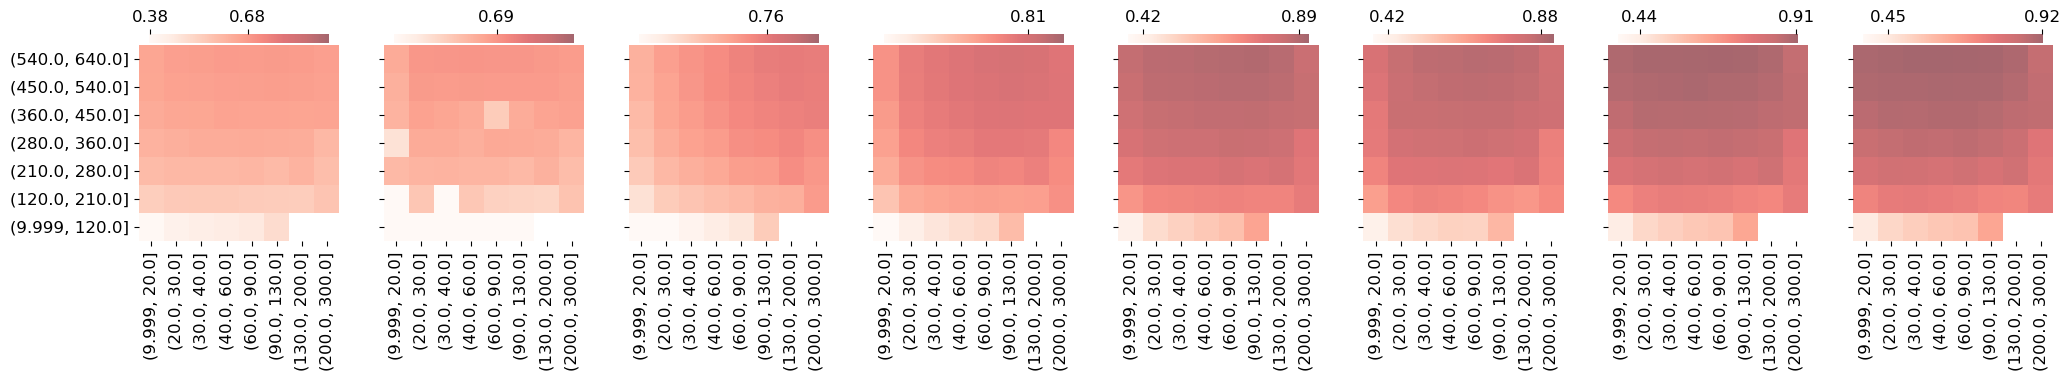

In [172]:
import matplotlib.ticker as ticker

# Define the desired number of bins in x and y axes
desired_x_bins = 9 #9
desired_y_bins = 7 #7
bin_type = 1 # 0 = even-width, 1 = even-quantity
mdls = ['wf','wc','kf','xgb','svr','dnn','rnn','gru','lstm']
mayo = 0

################# R2 ###################
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,8, figsize=(20,3), sharex=True, sharey=True)
fig.tight_layout()

for i,m in enumerate(df['model'].unique()):
    
    DF = df.loc[(df['output']=='position') & (df['model']==m)]
    dff = DF[['R2_mn','input_binWidth','input_timeWindow']]

    if bin_type==0:
        x_bin_width = (df['input_binWidth'].max() - df['input_binWidth'].min()) / desired_x_bins
        y_bin_width = (df['input_timeWindow'].max() - df['input_timeWindow'].min()) / desired_y_bins

        df_m = dff.groupby([
            pd.cut(dff['input_binWidth'], bins=desired_x_bins, include_lowest=True),
            pd.cut(dff['input_timeWindow'], bins=desired_y_bins, include_lowest=True)
        ])["R2_mn"].mean().reset_index(name="R2")
    elif bin_type==1:
        df_m = dff.groupby([
            pd.qcut(dff['input_binWidth'], q=desired_x_bins, duplicates='drop'),
            pd.qcut(dff['input_timeWindow'], q=desired_y_bins, duplicates='drop')
        ])["R2_mn"].mean().reset_index(name="R2")
    
    # Pivot the data for heatmap
    result = df_m.pivot(index='input_timeWindow', columns='input_binWidth', values='R2')
    
    a = sns.heatmap(ax=ax[i], data=result, cmap="Reds", mask=result.isnull(), alpha=0.6,
                    xticklabels=1, yticklabels=1, vmin=0.38, vmax=0.92,
                    cbar_kws={'location': 'top', 'ticks': [np.min(result), np.max(result)],
                                                            'orientation': 'horizontal', 'pad': 0.01, "shrink": 0.9,
                                                            'format': ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')})
    #, vmin=0.42, vmax=0.91,
    a.invert_yaxis()
    plt.yticks(rotation=0)
    if mayo==0:
        a.set(xlabel=None)
        a.set(ylabel=None)
        fig.savefig(fig_folder+'/r2htmp_inBinWidth-posVelAcc.png', dpi=600, bbox_inches='tight')
    else:
        a.set_title(mdls[m], pad=30)
    
    

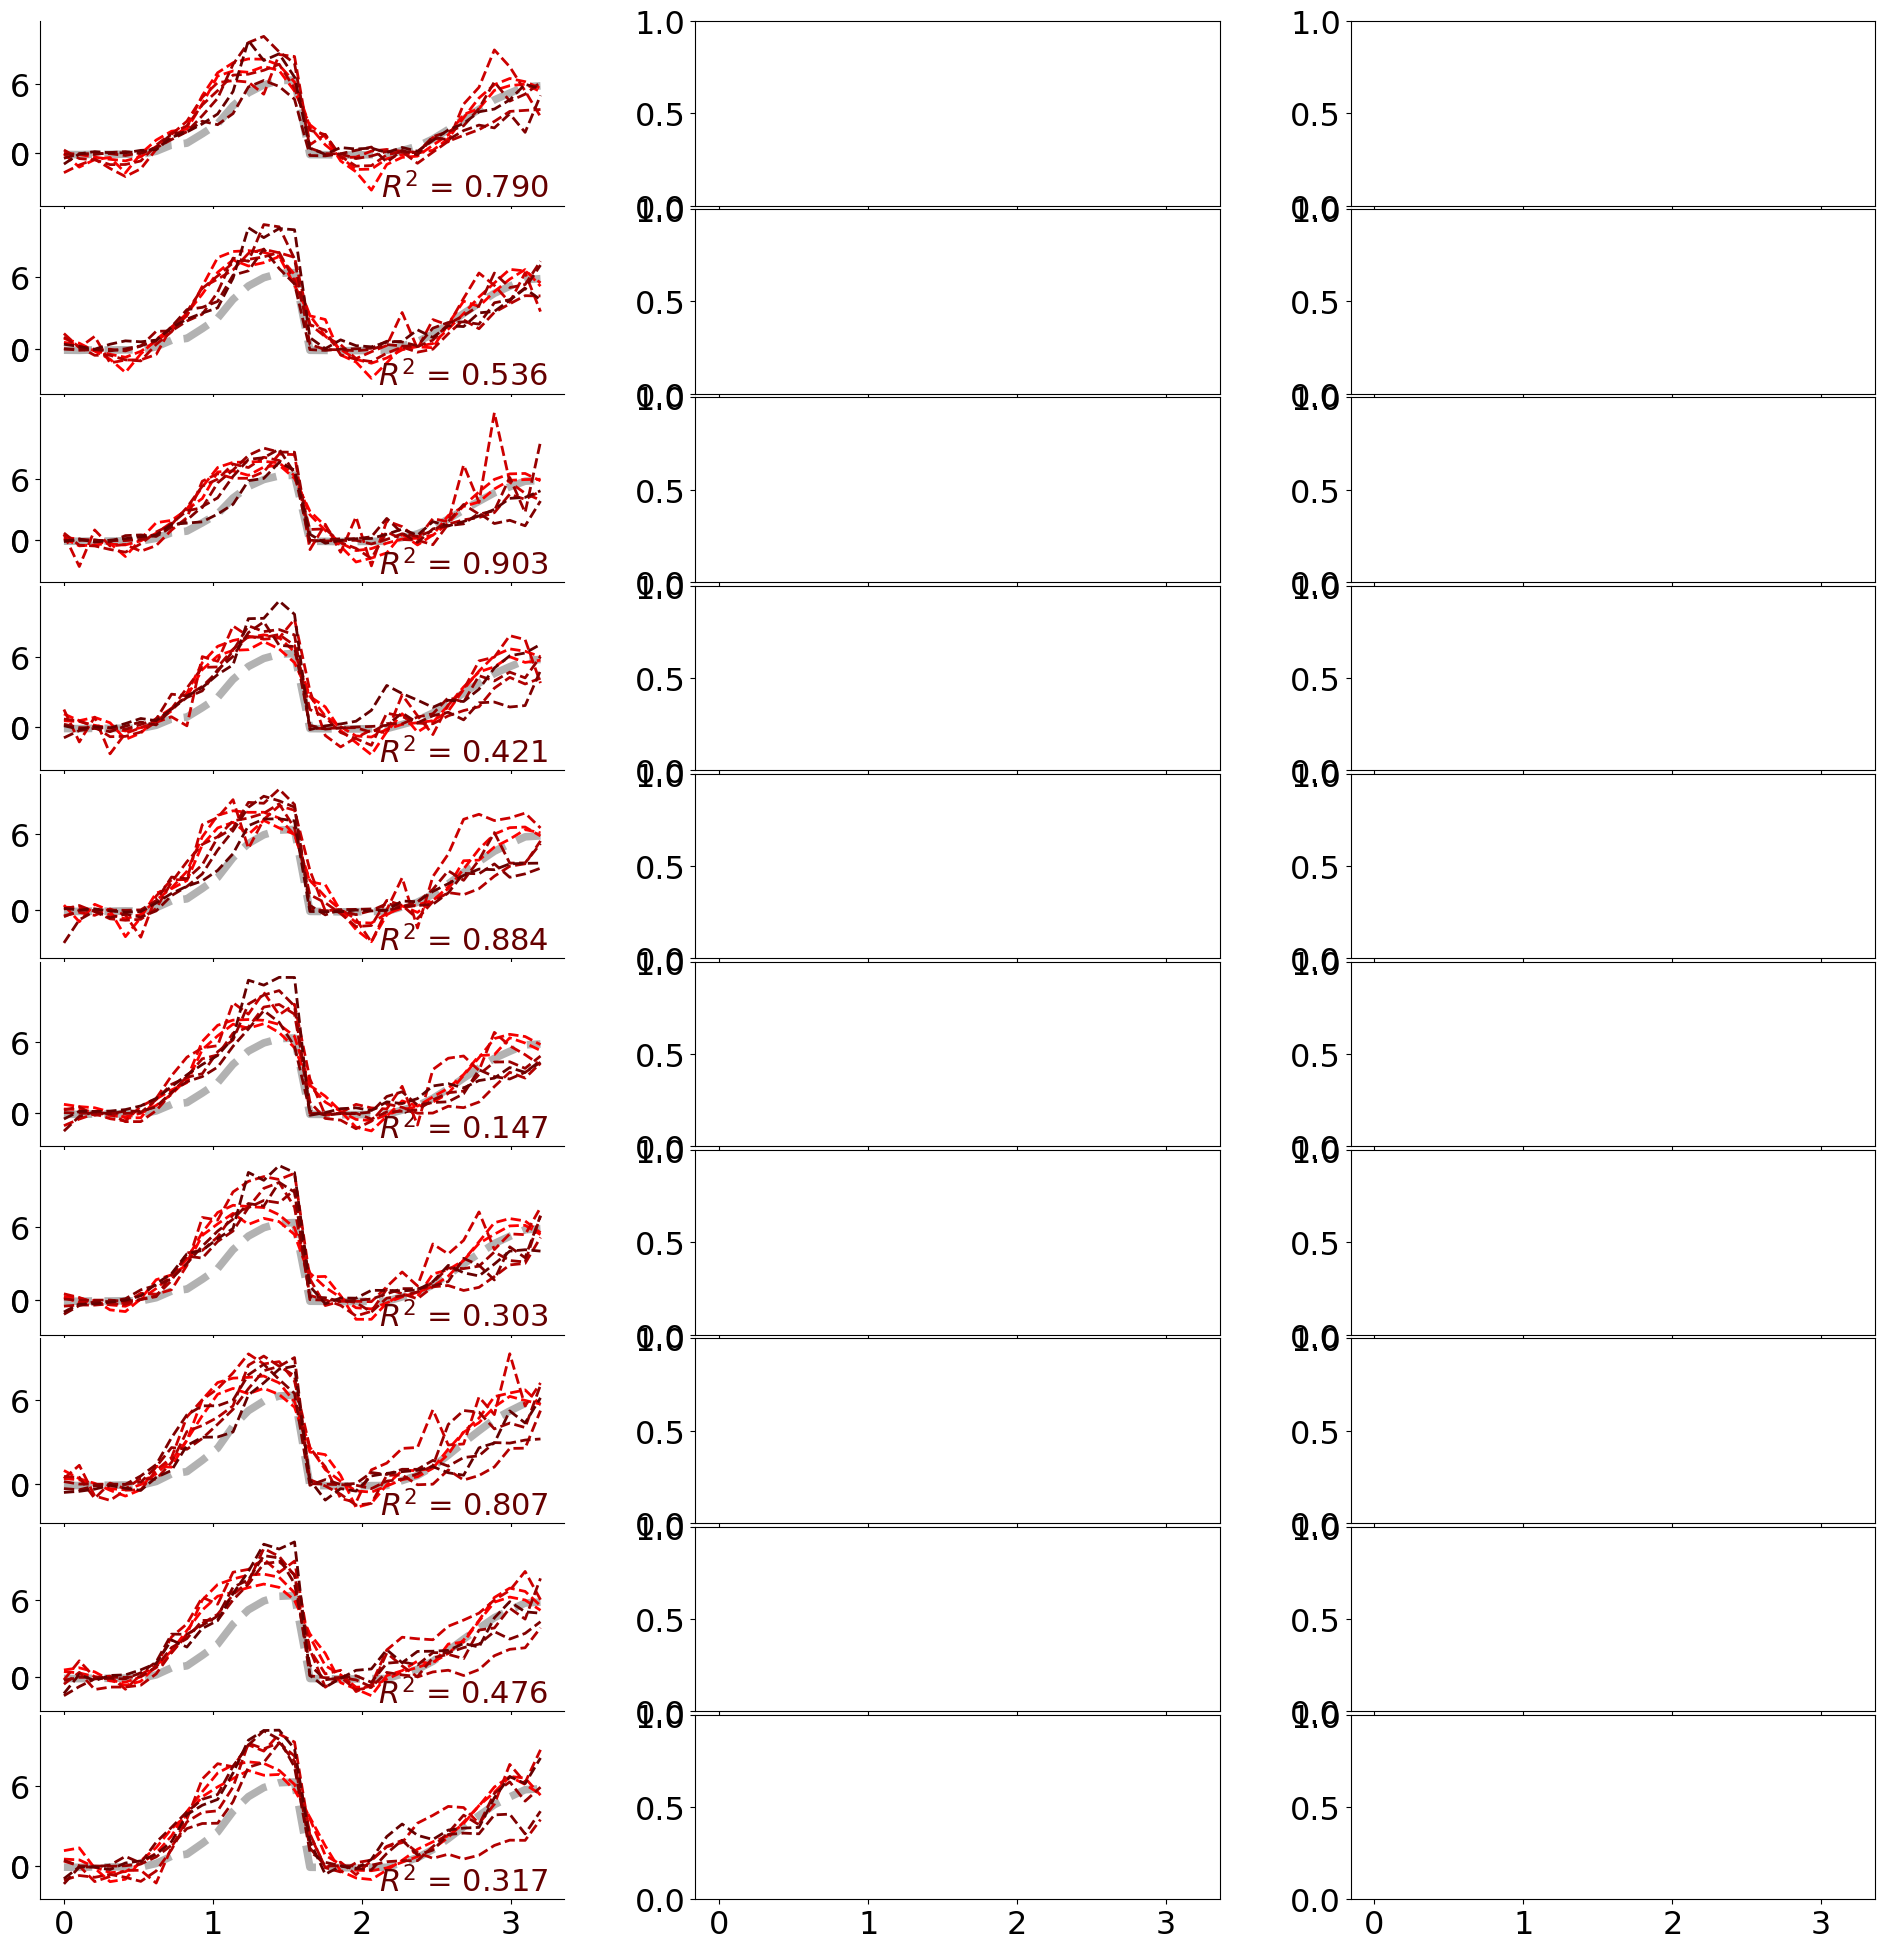

In [181]:
bws = [20,30,40,50,60,100,120,150,200,300]
mayo = 0
Nts = 2

plt.rcParams.update({'font.size': 23})
fig, axes = plt.subplots(len(bws),3,figsize=(20,20), sharex=True, sharey=False)#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 2
mdls = df0[(df0['outer_fold'] == best_fold) & (df0['input_binWidth'] == 100) & (df0['input_timeWindow'] == 600) &(df0['R2_mn']>-1)].index.values
jmdls =[0,1,3,4,5,6,7]

conds = conds0[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

y_test = yTest_all0
y_test_predicted = yTestPred_all0
    
R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 4
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)

plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

plot_trls = bad_trls

#################
R2_allParams = np.zeros((len(bws),3))
for b, bw in enumerate(bws):
    for k in range(1):
        if k==0:
            y_test = yTest_all0
            y_test_predicted = yTestPred_all0
            DF = df0
        elif k==1:
            y_test = yTest_all1
            y_test_predicted = yTestPred_all1
            DF = df1
        else:
            y_test = yTest_all2
            y_test_predicted = yTestPred_all2
            DF = df2
            
        mdls = DF[(DF['outer_fold'] == best_fold) & (DF['input_binWidth'] == bw) & (df0['input_timeWindow'] == 600) & (DF['R2_mn']>-1)].index.values
        jmdls =[0,1,3,4,5,6,7]

        conds = conds0[mdls[0]]
        trl_nums = np.unique(conds[:,0])
        trl_nums, indices = np.unique(conds[:,0], return_index=True)

        start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
        #x = np.arange(0, start_end.shape[0]*bw*Nts, bw*Nts)*2 / 10000
        x = np.linspace(0,Nts*1.6,start_end.shape[0])
        
        axes[b,k].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.5, linewidth=5.5, linestyle='dashed', label='true (horizontal)',zorder=0)
        for i,j in zip(mdls,jmdls):
            if j!=4:
                axes[b,k].plot(x,y_test_predicted[i][start_end,0], color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)
                R2_allParams[b,k] = get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0])
            else:
                axes[b,k].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)
                R2_allParams[b,k] = get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]))
           
        axes[b,k].spines['right'].set_color('none')
        axes[b,k].spines['top'].set_color('none')
        axes[b,k].set_yticks([round(min(y_test[i][start_end,0])),0,round(max(y_test[i][start_end,0]))])
        
        if k==0:
            axes[b, k].margins(y=0.1)
        elif k==1:
            axes[b, k].margins(y=0.2)
        else:
            axes[b, k].margins(y=0.1)
        
        text_box = f"$R^2$ = {R2_allParams[b, k]:.3f}"
        axes[b, k].text(0.97, 0.01, text_box, transform=axes[b, k].transAxes, fontsize=22, ha='right', va='bottom', color=reds[j])
    if mayo==1:
        axes[b,0].set_ylabel(f'bw={bw}')
        
#axes[0,0].set_xticks([0,2,4,6,8,10])

plt.subplots_adjust(wspace=0.25, hspace=0.02)
if mayo==1:
    axes[0, 0].set_title('position')
    axes[0, 1].set_title('velocity')
    axes[0, 2].set_title('acceleration')
    axes[3, 1].set_xlabel('time (ms)')
else:
    blah = 1
    #fig.savefig(fig_folder+'/traces_outBinWidth-posVelAcc.png', dpi=600, bbox_inches='tight')